# SIR
----


## Bibliotecas

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch
import deepxde as dde

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
# Para reprodução dos experimentos
dde.config.set_random_seed(1000)

## Modelo SIR

$$
\frac{dS}{dt} = −βSI
$$
$$
\frac{dI}{dt} = βSI − γI
$$
$$
\frac{dR}{dt} = γI.
$$

In [122]:
beta = 1.5
gamma = 0.8

In [123]:
def sir_model(t, y):

    S, I, R = y[:, 0:1], y[:, 1:2], y[:, 2:3]
    
    dS_dt = dde.grad.jacobian(y, t, i=0)
    dI_dt = dde.grad.jacobian(y, t, i=1)
    dR_dt = dde.grad.jacobian(y, t, i=2)
    
    return [
        dS_dt - (-beta * S * I),
        dI_dt - (beta * S * I - gamma * I),
        dR_dt - (gamma * I)   
    ]

## Limites

In [124]:
t0, tf = 0, 30
geom = dde.geometry.TimeDomain(t0, tf)

## Condições iniciais

In [125]:
S0 = 0.99
I0 = 0.01
R0 = 0.00

ic_S = dde.icbc.IC(geom, lambda _: S0, lambda _, on_initial: on_initial, component=0)
ic_I = dde.icbc.IC(geom, lambda _: I0, lambda _, on_initial: on_initial, component=1)
ic_R = dde.icbc.IC(geom, lambda _: R0, lambda _, on_initial: on_initial, component=2)

## Dados de treinamento

In [126]:
data = dde.data.PDE(
    geom, 
    sir_model, 
    [ic_S, ic_I, ic_R],
    num_domain=100, 
    num_boundary=2,
    num_test=50
)

## Configuração da rede

In [127]:
net = dde.nn.FNN([1] + [50] * 3 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)
model.compile("adam", lr=0.001)

Compiling model...
'compile' took 0.000218 s



## Treinamento

In [128]:
losshistory, train_state = model.train(
    iterations=20000, 
    model_save_path="../modelos/sir")

dde.saveplot(
    losshistory, 
    train_state, 
    output_dir="../treinamentos",
    loss_fname="sir_losses.dat",
    train_fname="sir_train.dat",
    test_fname="sir_test.dat",
    issave=True, 
    isplot=False)

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [3.91e-03, 7.49e-02, 4.77e-02, 9.80e-01, 1.00e-04, 0.00e+00]    [3.53e-03, 7.63e-02, 4.84e-02, 9.80e-01, 1.00e-04, 0.00e+00]    []  
1000      [1.54e-05, 1.27e-05, 2.66e-07, 2.46e-09, 3.21e-07, 9.02e-13]    [7.18e-06, 1.29e-05, 2.43e-07, 2.46e-09, 3.21e-07, 9.02e-13]    []  
2000      [9.08e-06, 2.67e-05, 1.36e-07, 1.21e-08, 7.66e-08, 1.96e-12]    [5.95e-06, 2.70e-05, 1.22e-07, 1.21e-08, 7.66e-08, 1.96e-12]    []  
3000      [9.30e-06, 2.25e-05, 1.83e-06, 1.04e-08, 1.20e-07, 2.37e-09]    [7.60e-06, 2.27e-05, 1.83e-06, 1.04e-08, 1.20e-07, 2.37e-09]    []  
4000      [4.52e-06, 2.43e-05, 2.98e-07, 1.72e-08, 4.84e-08, 7.61e-12]    [3.47e-06, 2.44e-05, 2.76e-07, 1.72e-08, 4.84e-08, 7.61e-12]    []  
5000      [2.17e-05, 1.77e-05, 1.39e-05, 4.14e-09, 7.62e-08, 3.54e-08]    [2.12e-05, 1.77e-05, 1.39e-05, 4.14e-09, 7

## Visualizando resultados

In [129]:
def plot_and_save_solution(solution, t_test, file_path):

    S, I, R = solution[:, 0], solution[:, 1], solution[:, 2]

    plt.plot(t_test, S, label="Suscetíveis (S)", linewidth=5)
    plt.plot(t_test, I, label="Infectados (I)", linewidth=5)
    plt.plot(t_test, R, label="Recuperados (R)", linewidth=5)
    
    plt.xlabel("Tempo (t)")
    plt.ylabel("Fração da População")
    
    plt.legend()
    plt.grid()
    plt.savefig(file_path)
    plt.show()

In [130]:
#model.restore("../modelos/sir-20000.pt")

In [131]:
NUMBER_OF_POINTS = 100

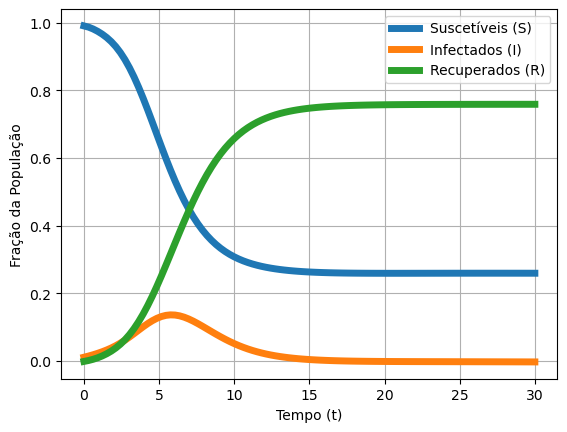

In [132]:
t_test = np.linspace(t0, tf, NUMBER_OF_POINTS)
y_pred = model.predict(t_test.reshape(-1, 1))
plot_and_save_solution(y_pred, t_test, "../figuras/sir_pinns.pdf")

## Comparação com métodos numéricos

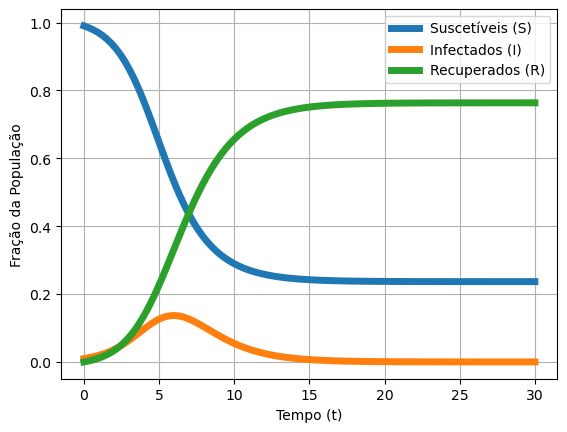

In [133]:

# Modelo SIR: dS/dt = -β S I, dI/dt = β S I - μ I, dR/dt = μ I
def sir_model(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    return np.array([dSdt, dIdt, dRdt])

# Implementação do método RK4
def rk4(f, y0, t, beta, gama):
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0

    for i in range(n - 1):
        dt = t[i+1] - t[i]
        k1 = f(y[i], t[i], beta, gama)
        k2 = f(y[i] + dt * k1 / 2, t[i] + dt / 2, beta, gamma)
        k3 = f(y[i] + dt * k2 / 2, t[i] + dt / 2, beta, gamma)
        k4 = f(y[i] + dt * k3, t[i] + dt, beta, gamma)
        y[i+1] = y[i] + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)

    return y

# Condições iniciais
y0 = np.array([S0, I0, R0])

# Intervalo de tempo
t = np.linspace(t0, tf, NUMBER_OF_POINTS)  # De 0 a 50, com 100 pontos

# Resolver o sistema SIR com RK4
sol = rk4(sir_model, y0, t, beta, gamma)

plot_and_save_solution(sol, t, "../figuras/sir_rk4.pdf")

## Analisando função de perda

In [134]:
def plot_and_save_losses(losshistory, file_path):

    X = losshistory.steps
    train = np.sum(losshistory.loss_train, axis=1)
    test = np.sum(losshistory.loss_test, axis=1)
    
    plt.semilogy(X, train, "o-", label="Treinamento", linewidth=2)
    plt.semilogy(X, test, "x-", label="Teste", linewidth=2)

    plt.xlabel("Iteração")
    plt.ylabel("Erro em escala logarítmica")
    
    plt.legend()
    plt.grid()
    plt.savefig(file_path)
    plt.show()

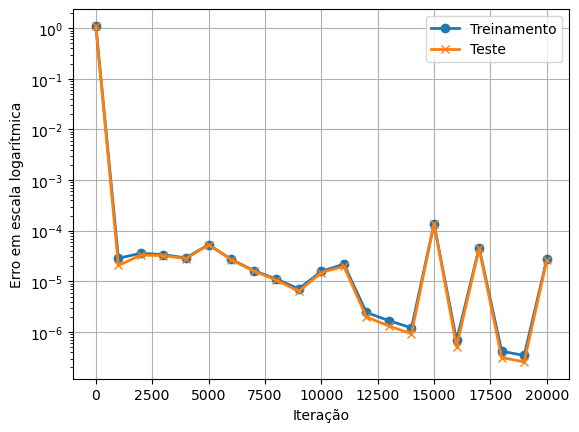

In [135]:
plot_and_save_losses(losshistory, "../figuras/sir_loss.pdf")

## Diferenças entre PINNs e Runge-Kutta

### Suscetíveis

In [138]:
scipy.linalg.norm(y_pred[:,0] - sol[:,0], ord=np.inf)

np.float64(0.023113873038288824)

### Infectados

In [141]:
scipy.linalg.norm(y_pred[:,1] - sol[:,1], ord=np.inf)

np.float64(0.00689157243663209)

### Recuperados

In [142]:
scipy.linalg.norm(y_pred[:,2] - sol[:,2], ord=np.inf)

np.float64(0.009167382002469304)